# Sequence-Aware Recommender Systems

In previous sections, we abstract the recommendation task as a matrix completion problem without considering users' short-term behaviors. In this section, we will introduce a recommendation model that takes  the sequentially-ordered user interaction logs into account.  It is a sequence-aware recommender where the input is an ordered and often timestamped list of past user actions.  A number of recent literatures have demonstrated the usefulness of incorporating such information in modeling users' temporal behavioral patterns and discovering their interest drift.  

The model we will introduce, Caser, short for convolutional sequence embedding recommendation model, adopts convolutional neural networks capture the dynamic pattern influences of users' recent activities. The main component of Caser consists of a horizontal convolutional network and a vertical convolutional network, aiming to uncover the union-level and point-level sequence patterns, respectively.  Point-level pattern indicates the impact of single item in the historical sequence on the target item, while union level pattern implies the influences of several previous actions on the subsequent target. For example, buying both milk and butter together leads to higher probability of buying flour than just buying one of them. Moreover, users' general interests, or long term preferences are also modeled in the last fully-connected layers, resulting in a more comprehensive modeling of user interests. Details of the model are described as follows.

## Model Architectures

In sequence-aware recommendation system, each user is associated with a sequence of some items from the item set. Let $S^u = (S_1^u, ... S_{|S_u|}^u)$ denotes the ordered sequence. The goal of Caser is to recommend item by considering user general tastes as well as short-term intention. Suppose we take the previous $L$ items into consideration, an embedding matrix that represents the former interactions for time step $t$ can be constructed:

$$
\mathbf{E}^{(u, t)} = [ \mathbf{q}_{S_{t-L}^u} , ...,  \mathbf{q}_{S_{t-2}^u}, \mathbf{q}_{S_{t-1}^u} ]^\top,
$$

where $\mathbf{Q} \in \mathbb{R}^{n \times k}$ represents item embeddings and $\mathbf{q}_i$ denotes the $i^\mathrm{th}$ row. $\mathbf{E}^{(u, t)} \in \mathbb{R}^{L \times k}$ can be used to infer the transient interest of user $u$ at time step $t$. We can view the input matrix $\mathbf{E}^{(u, t)}$ as an image which is the input of the subsequent two convolutional components.

The horizontal convolutional layer has $d$ horizontal filters $\mathbf{F}^j \in \mathbb{R}^{h \times k}, 1 \leq j \leq d, h = \{1, ..., L\}$, and the veritical convolutional layer has $d'$ vertical filters $\mathbf{G}^j \in \mathbb{R}^{ L \times 1}, 1 \leq j \leq d'$. After a series of convolutional and pool operations, we get the two outputs:

$$
\mathbf{o} = \text{HConv}(\mathbf{E}^{(u, t)}, \mathbf{F}) \\
\mathbf{o}'= \text{VConv}(\mathbf{E}^{(u, t)}, \mathbf{G}) ,
$$

where $\mathbf{o} \in \mathbb{R}^d$ is the output of horizontal convolutional network and $\mathbf{o}' \in \mathbb{R}^{kd'}$ is the output of vertical convolutional network. For simplicity, we omit the details of convolution and pool operations. They are concatenated and fed into a fully-connected neural network layer to get more high-level representations.

$$
\mathbf{z} = \phi(\mathbf{W}[\mathbf{o}, \mathbf{o}']^\top + \mathbf{b}),
$$

where $\mathbf{W} \in \mathbb{R}^{k \times (d + kd')}$ is the weight matrix and $\mathbf{b} \in \mathbb{R}^k$ is the bias. The learned vector $\mathbf{z} \in \mathbb{R}^k$ is the representation of user's short-term intent.

At last, the prediction function combines users' short-term and general taste together, which is defined as:

$$
\hat{y}_{uit} = \mathbf{v}_i \cdot [\mathbf{z}, \mathbf{p}_u]^\top + \mathbf{b}'_i,
$$

where $\mathbf{V} \in \mathbb{R}^{n \times 2k}$ is another item embedding matrix. $\mathbf{b}' \in \mathbb{R}^n$ is the item specific bias.  $\mathbf{P} \in \mathbb{R}^{m \times k}$ is the user embedding matrix for users' general tastes. $\mathbf{p}_u \in \mathbb{R}^{ k}$ is the $u^\mathrm{th}$ row of $P$ and $\mathbf{v}_i \in \mathbb{R}^{2k}$ is the $i^\mathrm{th}$ row of $\mathbf{V}$.

The model can be learned with BPR or Hinge loss. The architecture of Caser is shown below:

![Illustration of the Caser Model](../img/rec-caser.svg)

We firstly import the required libraries.

In [1]:
import d2l
from mxnet import autograd, init, gluon, np, npx
from mxnet.gluon.data import Dataset
from mxnet.gluon import nn
import mxnet as mx
import sys
npx.set_np()

## Model Implementation
The following code implements the Caser model. It consists of a vertical convolutional layer, a horizontal convolutional layer, and a full-connected layer.

In [2]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully-connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)
    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis= 3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis = 2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1)  + b
        return res

## Sequential DataLoader
To process the sequential interaction data, we need to reimplement the Dataset class. The following code creates a new dataset class named `SeqDataset`. In each sample, it outputs the user identity, her previous $L$ interacted items as a sequence and the next item she interacts as the target. The following figure demonstrates the data loading process for one user. Suppose that this user liked 8 movies, we organize these eight movies in chronological order. The latest movie is left out as the test item. For the remaining seven movies, we can get three training samples, with each sample containing a sequence of five ($L=5$) movies and its subsequent item as the target item.

![Illustration of the data generation process](../img/rec-seq-data.svg)

In [3]:
class SeqDataset(Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids = {}, u_ids.asnumpy()
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns,L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt, self.test_seq = np.zeros((ns,1)),np.zeros((num_users,L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid
    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size : i]
                else:
                    break
        else:
            yield tensor
    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)
    def __len__(self):
        return self.ns
    def __getitem__(self, i):
        return self.seq_users[i], self.seq_items[i], self.seq_tgt[i]

## Load the MovieLens 100K dataset

Afterwards, we read and split the MovieLens 100K dataset in sequence-aware mode and load the training data with sequential dataloader implemented above.

In [4]:
TARGET_NUM, L, batch_size = 1, 5, 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit" )
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items)
num_workers = 0 if sys.platform.startswith("win") else 4
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover", 
                                   num_workers=num_workers)
test_seq_iter = train_seq_data.test_seq
train_seq_data[0]

(array(0, dtype=int32), array([241., 170., 110., 255.,   4.]), array([101.]))

The training data structure is shown above. The first element is the user identity, the next list indicates the last five items this user liked, and the last element is the item this user liked after the five items.

## Train the Model
Now, let us train the model. We use the same setting as NeuMF, including learning rate, optimizer, and $k$, in the last section so that the results are comparable.

train loss 3.904, test hit rate 0.369, test AUC 0.747
8.2 examples/sec on [gpu(0), gpu(1)]


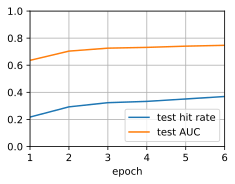

In [5]:
ctx = d2l.try_all_gpus()
net = Caser(10, num_users, num_items, L)
net.initialize(ctx=ctx, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.01, 6, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

d2l.train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, ctx, d2l.evaluate_ranking,
                  d2l.negative_sampler, candidates, eval_step=1)

## Summary
* Inferring a user's short-term and long-term interests can make prediction of the next item that she preferred more effectively.
* Convolutional neural networks can be utilized to capture users' short-term interests from sequential interactions.

## Exercises
* Conduct an ablation study by removing one of the horizontal and vertical convolutional networks, which component is the more important ?
* Vary the hyperparameter $L$. Does longer historical interactions bring higher accuracy?